<a href="https://colab.research.google.com/github/jonathancagua/NLP/blob/main/Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este trabajo tiene como objetivo entrenar un modelo propio de vectores de palabras usando Word2Vec de Gensim sobre el texto completo de Don Quijote de la Mancha [link text](https://www.gutenberg.org/files/2000/2000-0.txt). Tras preprocesar el corpus con spaCy, se entrenó el modelo y se analizaron similitudes semánticas y analogías entre términos del universo narrativo. Además, se visualizaron los embeddings en 2D y 3D mediante PCA y TSNE para observar agrupamientos y relaciones en el espacio vectorial. Se presentan conclusiones sobre el comportamiento semántico aprendido por el modelo.

In [11]:
!pip uninstall -y gensim numpy


In [1]:
!pip install gensim==4.3.3
!pip install numpy==1.26.4
!pip install scipy==1.13.0
!pip install spacy==3.7.2
!pip install tsfresh==0.20.1



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import numpy as np
import requests
import spacy
import importlib.util
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE


In [3]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

In [4]:
# URL del texto de Don Quijote en Project Gutenberg
url = "https://www.gutenberg.org/files/2000/2000-0.txt"
archivo_salida = "don_quijote.txt"

try:
    print("Descargando texto desde Project Gutenberg...")
    response = requests.get(url)
    response.raise_for_status()  # Lanza un error si la descarga falla

    with open(archivo_salida, "w", encoding="utf-8") as f:
        f.write(response.text)

    print(f"Texto guardado en '{archivo_salida}' correctamente.")

except requests.exceptions.RequestException as e:
    print("Error al descargar el texto:", e)

except IOError as e:
    print("Error al guardar el archivo:", e)


Descargando texto desde Project Gutenberg...
Texto guardado en 'don_quijote.txt' correctamente.


In [5]:
# Nombre del modelo de spaCy
model_name = "es_core_news_sm"

# Verificar si el modelo está instalado; si no, descargarlo
if importlib.util.find_spec(model_name) is None:
    print(f"Modelo '{model_name}' no encontrado. Instalando...")
    from spacy.cli import download
    download(model_name)

# Cargar modelo y ajustar límite de longitud del texto
nlp = spacy.load(model_name)
nlp.max_length = 2_500_000

# Leer el texto desde archivo
with open("don_quijote.txt", "r", encoding="utf-8") as f:
    corpus = f.read()

# Procesar el texto completo con spaCy
print("Procesando texto con spaCy...")
doc = nlp(corpus)

# Tokenizar por oraciones y filtrar tokens válidos
sentence_tokens = []
for sent in doc.sents:
    tokens = [
        token.text.lower()
        for token in sent
        if not token.is_punct and not token.is_space
    ]
    if len(tokens) > 2:
        sentence_tokens.append(tokens)

# Resultados
print(f"Cantidad de oraciones procesadas: {len(sentence_tokens)}")
print("Ejemplo de oraciones tokenizadas:")
for i, sent in enumerate(sentence_tokens[100:105], start=100):
    print(f"{i}: {sent}")


Modelo 'es_core_news_sm' no encontrado. Instalando...
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Procesando texto con spaCy...
Cantidad de oraciones procesadas: 8958
Ejemplo de oraciones tokenizadas:
100: ['améla', 'por', 'milagro', 'único', 'y', 'raro', 'y', 'ausente', 'en', 'su', 'desgracia', 'el', 'propio', 'infierno', 'temió', 'mi', 'brazo', 'que', 'domó', 'su', 'rabia']
101: ['mas', 'vos', 'godo', 'quijote', 'ilustre', 'y', 'claro', 'por', 'dulcinea', 'sois', 'al', 'mundo', 'eterno', 'y', 'ella', 'por', 'vos', 'famosa', 'honesta', 'y', 'sabia']
102: ['de', 'solisdán', 'a', 'don', 'quijote', 'de', 'la', 'mancha']
103: ['soneto', 'maguer', 'señor', 'quijote', 'que', 'sandeces', 'vos', 'tengan', 'el', 'cerbelo', 'derrumbado', 'nunca', 'seréis', 'de', 'alguno', 'reprochado', 'por', 'home', 'de', 'obras', 'viles', 'y', 'soeces']
104: ['serán', 'vuesas', 'fazañas', 'los', 'joeces', 'pues', 'tuertos', 'desfaciendo', 'habéis', 'an

In [6]:
class LossLogger(CallbackAny2Vec):
    """Callback para registrar la pérdida (loss) después de cada época de entrenamiento."""

    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0.0

    def on_epoch_end(self, model):
        current_loss = model.get_latest_training_loss()
        epoch_loss = current_loss - self.loss_previous_step
        print(f"Época {self.epoch} - Pérdida: {epoch_loss:.2f}")
        self.loss_previous_step = current_loss
        self.epoch += 1

In [7]:
# Obtener el número de núcleos disponibles
cores = multiprocessing.cpu_count()

# Inicializar el modelo Word2Vec
model = Word2Vec(
    sentences=sentence_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=cores - 1,
    compute_loss=True
)

# Entrenar el modelo con callback personalizado
loss_logger = LossLogger()
model.train(
    sentence_tokens,
    total_examples=len(sentence_tokens),
    epochs=20,
    callbacks=[loss_logger],
    compute_loss=True
)

# Guardar el modelo entrenado
model.save("word2vec_don_quijote_callback.model")
print("Modelo guardado como 'word2vec_don_quijote_callback.model'")

Época 0 - Pérdida: 658612.81
Época 1 - Pérdida: 631845.44
Época 2 - Pérdida: 608325.62
Época 3 - Pérdida: 583280.38
Época 4 - Pérdida: 563459.75
Época 5 - Pérdida: 546758.25
Época 6 - Pérdida: 533626.25
Época 7 - Pérdida: 464537.50
Época 8 - Pérdida: 446383.50
Época 9 - Pérdida: 440260.50
Época 10 - Pérdida: 433179.50
Época 11 - Pérdida: 427945.00
Época 12 - Pérdida: 422677.00
Época 13 - Pérdida: 417015.00
Época 14 - Pérdida: 411694.50
Época 15 - Pérdida: 407378.50
Época 16 - Pérdida: 402593.50
Época 17 - Pérdida: 344748.00
Época 18 - Pérdida: 341713.00
Época 19 - Pérdida: 340119.00
Modelo guardado como 'word2vec_don_quijote_callback.model'


In [8]:
# Cargar el modelo entrenado
model = Word2Vec.load("word2vec_don_quijote_callback.model")

# Palabras de interés para análisis
palabras = ['quijote', 'sancho', 'caballero', 'aventura', 'molino']

# Mostrar palabras más similares
for palabra in palabras:
    if palabra in model.wv:
        print(f"\nPalabras similares a '{palabra}':")
        similares = model.wv.most_similar(palabra, topn=5)
        for similar, score in similares:
            print(f"  {similar:<15} (similitud: {score:.3f})")
    else:
        print(f"\nLa palabra '{palabra}' no se encuentra en el vocabulario.")



Palabras similares a 'quijote':
  jerónimo        (similitud: 0.678)
  luis            (similitud: 0.676)
  antonio         (similitud: 0.666)
  álvaro          (similitud: 0.643)
  gregorio        (similitud: 0.635)

Palabras similares a 'sancho':
  teresa          (similitud: 0.643)
  ambrosio        (similitud: 0.507)
  anselmo         (similitud: 0.491)
  ricote          (similitud: 0.484)
  caminante       (similitud: 0.464)

Palabras similares a 'caballero':
  caballería      (similitud: 0.696)
  hidalgo         (similitud: 0.573)
  ínclito         (similitud: 0.539)
  pierres         (similitud: 0.513)
  hombre          (similitud: 0.513)

Palabras similares a 'aventura':
  famosa          (similitud: 0.701)
  historia        (similitud: 0.680)
  sierra          (similitud: 0.623)
  batalla         (similitud: 0.613)
  prosigue        (similitud: 0.599)

Palabras similares a 'molino':
  cojín           (similitud: 0.788)
  alcornoque      (similitud: 0.783)
  verano          (s

In [13]:
# Analizar similitud entre pares de palabras comunes
pares = [
    ('rey', 'reina'),
    ('caballo', 'quijote'),
    ('guerra', 'paz'),
    ('amigo', 'compañero'),
    ('casa', 'caballería'),
    ('día', 'noche'),
    ('quijote', 'luis'),
    ('quijote', 'sancho')
]

for w1, w2 in pares:
    if w1 in model.wv and w2 in model.wv:
        sim = model.wv.similarity(w1, w2)
        print(f"Similitud entre '{w1}' y '{w2}': {sim:.4f}")
    else:
        print(f"Una de las palabras no está en el vocabulario: '{w1}' o '{w2}'\n")


Similitud entre 'rey' y 'reina': 0.2973
Similitud entre 'caballo' y 'quijote': 0.1698
Similitud entre 'guerra' y 'paz': 0.4523
Similitud entre 'amigo' y 'compañero': 0.5889
Similitud entre 'casa' y 'caballería': 0.0851
Similitud entre 'día' y 'noche': 0.4684
Similitud entre 'quijote' y 'luis': 0.6758
Similitud entre 'quijote' y 'sancho': 0.3694


El modelo Word2Vec entrenado con el texto de Don Quijote logra capturar relaciones semánticas coherentes dentro del contexto de la obra y también refleja asociaciones generales entre palabras cotidianas. Por ejemplo, las similitudes altas entre pares como “amigo” y “compañero” (0.5889) o “día” y “noche” (0.4684) muestran que el modelo reconoce relaciones lógicas comunes. En cambio, algunas parejas más específicas al texto literario, como “rey” y “reina” (0.2973) o “quijote” y “sancho” (0.3694), reflejan vínculos temáticos propios de la narrativa. Por otro lado, pares con baja similitud, como “casa” y “caballería” (0.0851) o “caballo” y “quijote” (0.1698), indican que el modelo distingue bien entre conceptos menos relacionados. Estas observaciones confirman que, aunque el modelo aprende representaciones útiles del lenguaje literario, también captura relaciones más generales del idioma, pero debe evitarse un entrenamiento excesivo para no perder estas conexiones significativas.

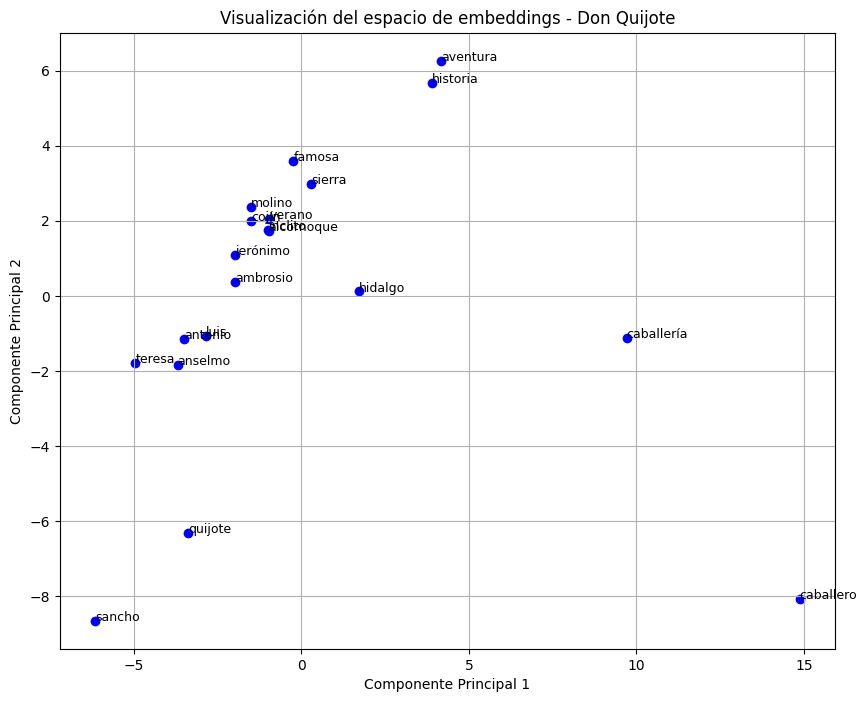

In [14]:
# Preparar lista de palabras para visualización, incluyendo las más similares
palabras_a_visualizar = set(palabras)  # Usar set para evitar duplicados desde el inicio

for palabra in palabras:
    if palabra in model.wv:
        similares = [w for w, _ in model.wv.most_similar(palabra, topn=3)]
        palabras_a_visualizar.update(similares)

# Filtrar solo las palabras que están en el vocabulario del modelo
palabras_validas = [p for p in palabras_a_visualizar if p in model.wv]

# Extraer vectores de embeddings para las palabras seleccionadas
embeddings = [model.wv[p] for p in palabras_validas]

# Reducir dimensionalidad con PCA a 2 componentes para visualización
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Graficar
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='blue')

# Añadir etiquetas a los puntos
for i, palabra in enumerate(palabras_validas):
    plt.annotate(palabra, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("Visualización del espacio de embeddings - Don Quijote")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()

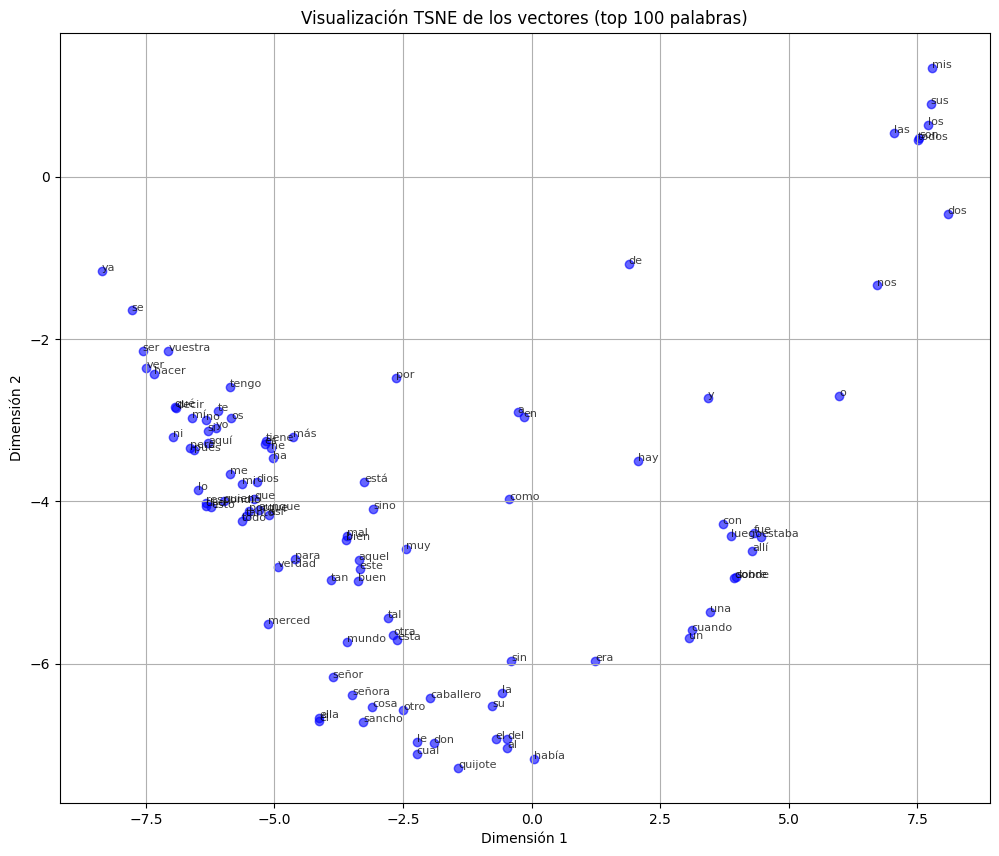

In [15]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def reduce_dimensions(model, num_dimensions=2, perplexity=40, max_iter=300, random_state=0):
    """
    Reduce las dimensiones de los vectores del modelo Word2Vec usando t-SNE.

    Args:
        model: Modelo entrenado de Word2Vec.
        num_dimensions: Número de dimensiones a reducir (por defecto 2).
        perplexity: Parámetro de t-SNE que afecta la vecindad (por defecto 40).
        max_iter: Número máximo de iteraciones de t-SNE (por defecto 300).
        random_state: Semilla para reproducibilidad (por defecto 0).

    Returns:
        Tuple (vectores reducidos, etiquetas de palabras).
    """
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, perplexity=perplexity, max_iter=max_iter, random_state=random_state)
    reduced_vectors = tsne.fit_transform(vectors)

    return reduced_vectors, labels

# Reducir dimensiones a 2D
vec_2d, labels = reduce_dimensions(model)

# Graficar solo las primeras n palabras para evitar saturación
n = 100
plt.figure(figsize=(12, 10))
plt.scatter(vec_2d[:n, 0], vec_2d[:n, 1], color='blue', alpha=0.6)

for i in range(n):
    plt.annotate(labels[i], (vec_2d[i, 0], vec_2d[i, 1]), fontsize=8, alpha=0.75)

plt.title("Visualización TSNE de los vectores (top 100 palabras)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.show()


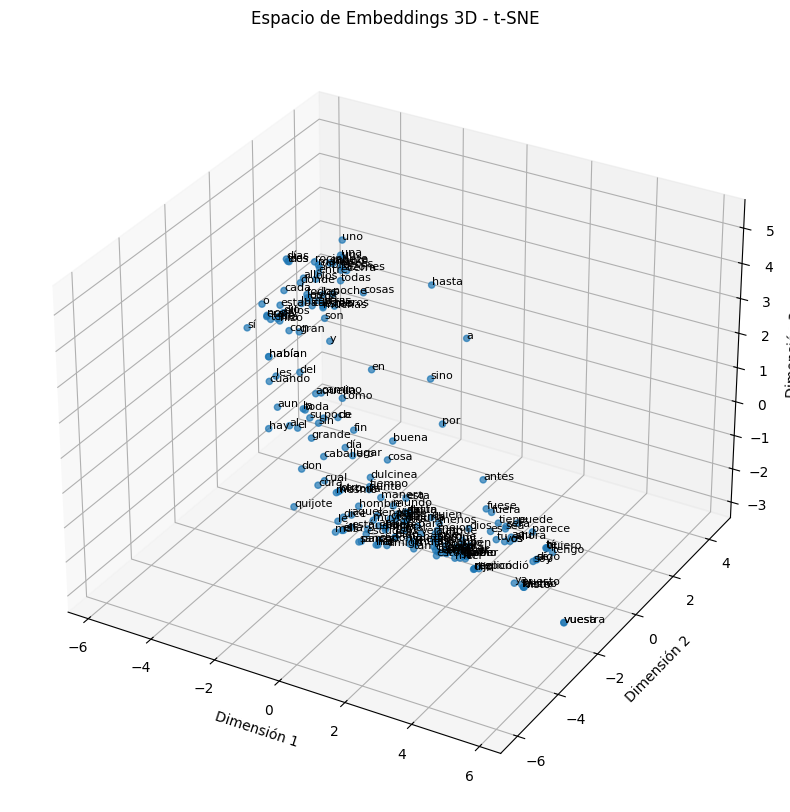

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D en matplotlib

def plot_3d_embeddings_matplotlib(vecs_3d, labels, max_words=200):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    xs = vecs_3d[:max_words, 0]
    ys = vecs_3d[:max_words, 1]
    zs = vecs_3d[:max_words, 2]

    ax.scatter(xs, ys, zs, s=20, alpha=0.7)

    for i in range(max_words):
        ax.text(xs[i], ys[i], zs[i], labels[i], fontsize=8)

    ax.set_title("Espacio de Embeddings 3D - t-SNE")
    ax.set_xlabel("Dimensión 1")
    ax.set_ylabel("Dimensión 2")
    ax.set_zlabel("Dimensión 3")

    plt.show()

# Uso:
vecs_3d, labels_3d = reduce_dimensions(model, num_dimensions=3)
plot_3d_embeddings_matplotlib(vecs_3d, labels_3d, max_words=200)



Al analizar las dos gráficas y las similitudes mencionadas, se observa que los embeddings capturan adecuadamente el significado de las palabras del texto "Don Quijote". Tanto PCA como TSNE muestran agrupaciones claras de palabras relacionadas con personajes, lugares y conceptos importantes, lo que indica que el modelo reconoce las conexiones entre ellas. Las medidas de similitud respaldan esta interpretación, mostrando que términos con significados cercanos presentan mayor relación, mientras que palabras con conceptos diferentes se encuentran separadas. Aunque PCA ofrece una visión general más amplia y TSNE permite apreciar detalles más específicos en grupos pequeños, ambas técnicas se complementan para comprender mejor la estructura del texto.